In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sympy import symbols, cos, sin
from sympy.plotting import plot_parametric
from math import sin,cos
import random

# Лабораторная работа 1.4 - Фильтр Рао-Блэквулла
Рассматривается приложение калмановской фильтрации к задаче определения ориентации абсолютно твердого тела на основе измерений, регистрируемых акселерометром и гироскопом. Реализован расширенный Фильтр Рао-Блэквулла, в рамках модели пространства состояний, изложенной в M. Kok, J. D. Hol and T. B. Schön (2017). Using Inertial Sensors for Position and Orientation Estimation. Foundations and Trends in Signal Processing: Vol. 11: No.
1-2, pp 1-153. doi: 10.1561/2000000094

In [2]:
# Начальные данные
#период дискретизации
T = 0.05
t = []
t.append(0)
# вектор ускорения свободного падения
g = np.array([0,0,9.81])
#матрица шума ориентации
w_n = np.array([[0.05,0.0,0.0],[0.0,0.05,0.0],[0.0,0.0,0.05]])
# матрица шума измерения
e_n = np.array([[0.1,0.0,0.0],[0.0,0.1,0.0],[0.0,0.0,0.1]])
# вектор состояния
q = np.array([0,1/3,1/3,1/3])
m  = []
P = []
m.append(q)
P.append(np.array([[0.1,0.0,0.0,0.0],[0.0,0.1,0.0,0.0],[0.0,0.0,0.1,0.0],[0.0,0.0,0.0,1.0]]))
# угловая скорость
w = np.array([0.5,0.5,0])
# количество измерений
N = 250
Q = []
X = []
X.append(q)
# Вектор наблюдений
Y = []
F_p = np.array([0.0,0.0,0.0])
Y.append(q)

In [3]:
def Q(q):
    return np.array([[2*q[0]**2-1+2*q[1]**2, 2*(q[1]*q[2]-q[0]*q[3]), 2*(q[1]*q[3]+q[0]*q[2])],
[2*(q[1]*q[2]+q[0]*q[3]), 2*q[0]**2-1+2*q[2]**2, 2*(q[2]*q[3]-q[0]*q[1])],
      [2*(q[1]*q[3]-q[0]*q[2]), 2*(q[2]*q[3]+q[0]*q[1]), 2*q[0]**2-1+2*q[3]**2]])


In [4]:
def Omega(w):
    return np.array([[0, -w[0], -w[1], -w[2]],
      [w[0],     0,  w[2], -w[1]],
      [w[1], -w[2],    0,   w[0]],
      [w[2],  w[1], -w[0],     0]])

In [5]:
def F_w(w):
    return np.array([[1.0,0.0,0.0,0.0],[0.0,1.0,0.0,0.0],[0.0,0.0,1.0,0.0],[0.0,0.0,0.0,1.0]]) + 0.5 * Omega(w) * T

In [6]:
def Xi(q):
    return np.array([[
      -q[1], -q[2], -q[3]],
      [ q[0], -q[3],  q[2]],
       [q[3],  q[0], -q[1]],
      [-q[2],  q[1],  q[0]]])

In [7]:
def F_q(q):
    return 0.5 * Xi(q)*T

In [8]:
def norm(q):
    sgn = 0
    if q[0] > 0 :
        sgn = 1
    if q[0] < 0 :
        sgn = -1
    l = math.sqrt(q[0]**2 + q[1]**2 + q[2]**2 + q[3]**2)
    return sgn * q / l


In [10]:
for i in range(1,N):
    t.append(i*T)
    y = np.dot(Q(q).transpose(),np.array(g + F_p + np.random.multivariate_normal([0,0,0],e_n)))
    q_ = np.dot(F_w(w),q)+ np.dot(F_q(q), np.random.multivariate_normal([0,0,0],w_n))
    q = norm(q_)
    X.append(q)
    Y.append(y)

In [11]:
def H(q):
    d_0 = np.array([
         [4*q[0],  2*q[3], -2*q[2]],
         [-2*q[3],  4*q[0],  2*q[1]],
         [2*q[2], -2*q[1],  4*q[0]]])
    d_1 = np.array([
        [4*q[1],  2*q[2],  2*q[3]],
        [2*q[2],       0,  2*q[0]],
        [2*q[3], -2*q[0],       0]])
    d_2 =np.array([ 
        [     0,  2*q[1], -2*q[0]],
        [2*q[1],  4*q[2],  2*q[3]],
        [2*q[0],  2*q[3],       0]])
    d_3 = np.array([
        [      0,  2*q[0],  2*q[1]],
        [-2*q[0],       0,  2*q[2]],
        [ 2*q[1],  2*q[2],  4*q[3]]])
    t0 = np.dot(d_0,g)
    t1 = np.dot(d_1,g)
    t2 = np.dot(d_2,g)
    t3 = np.dot(d_3,g)
    ans  = np.array([[t0[0],t1[0],t2[0],t3[0]],[t0[1],t1[1],t2[1],t3[1]],[t0[2],t1[2],t2[2],t3[2]]])
    return ans

In [12]:
for i in range(1,len(Y)):
    # Прогноз
    m_ = np.dot(F_w(w),m[-1])
    p_ = np.dot(np.dot(F_w(w),P[-1]),(F_w(w)).transpose()) + np.dot(np.dot(F_q(m[-1]), w_n) , F_q(m[-1]).transpose())

    # Коррекция
    S = np.dot(np.dot(H(m_),p_),H(m_).transpose())+ w_n
    K = np.dot(np.dot(p_ ,H(m_).transpose()), np.linalg.inv(S))
    y_ = np.dot(Q(m_).transpose(),np.array(g + F_p))
    v = Y[i]  - y_;
   # print(v)
   # print(K)
    v = np.dot(K , v.transpose())
    v = v.tolist();
    q =  norm(m_  + v)
    m.append(q)
#    print(m_ + v)
 #   print(p_  - np.dot(np.dot(K ,S),K.transpose()))
    P.append(p_  - np.dot(np.dot(K ,S),K.transpose()))


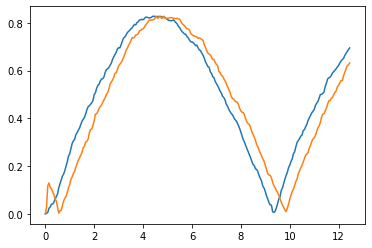

In [13]:
x = t
y = [a[0] for a in X]
fig3 = plt.figure(1)
axes1 = fig3.subplots(1, 1)
axes1.plot(x, [a[0] for a in X],label='parametric curve')
axes1.plot(x, [a[0] for a in m],label='parametric curve')

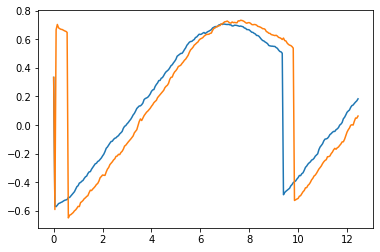

In [14]:
x = t
fig1 = plt.figure(1)
axes1 = fig1.subplots(1, 1)
axes1.plot(x, [a[1] for a in X],label='parametric curve')
axes1.plot(x, [a[1] for a in m],label='parametric curve')

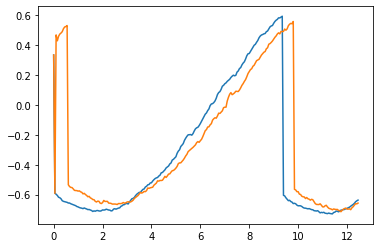

In [15]:
x = t
fig2 = plt.figure(1)
axes1 = fig2.subplots(1, 1)
axes1.plot(x, [a[2] for a in X],label='parametric curve')
axes1.plot(x, [a[2] for a in m],label='parametric curve')

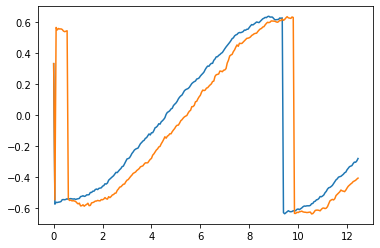

In [16]:
x = t
fig4 = plt.figure(1)
axes1 = fig4.subplots(1, 1)
axes1.plot(x, [a[3] for a in X],label='parametric curve')
axes1.plot(x, [a[3] for a in m],label='parametric curve')